# Ultimate Takehome Challenge

In [77]:
# imports
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

In [11]:
# seaborn settings
sns.set_style('whitegrid')

## Part 1 ‐ Exploratory Data Analysis

Aggregate these login counts based on 15-minute time intervals. Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand: report/illustrate important features of the demand, such as daily cycles. 

#### Ingest and Clean Data

In [2]:
logins = pd.read_json('/Users/trqk-data/Documents/springboard/json/logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


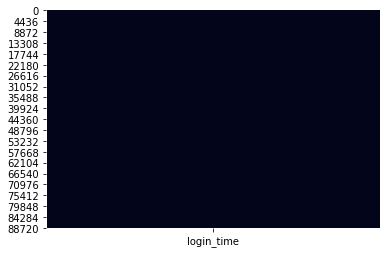

In [5]:
sns.heatmap(logins.isnull(), cbar=False)

#### Reample at Every Fifteen Minutes

In [6]:
logins = logins.set_index('login_time')

In [9]:
logins['dummy'] = 1

In [17]:
fifteens = logins.groupby('dummy').resample('15min').count().reset_index('dummy', drop=True)

In [18]:
fifteens.head()

,dummy
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


#### Visualize Daily Pattern

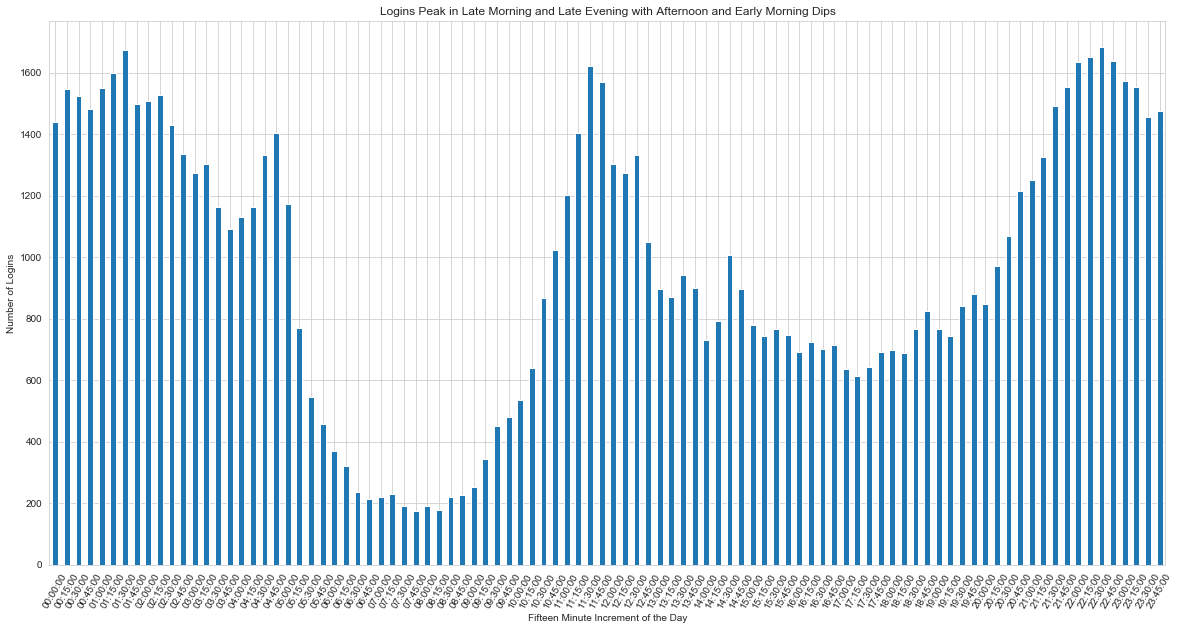

In [59]:
fifteens.groupby(fifteens.index.time).sum().plot(kind='bar', legend=False, figsize=(20,10))
plt.xticks(rotation=60)
plt.title('Logins Peak in Late Morning and Late Evening with Afternoon and Early Morning Dips')
plt.ylabel('Number of Logins')
plt.xlabel('Fifteen Minute Increment of the Day')
plt.show()

Although it doesn't impact this analysis, it's worth noting that the year has been incorrectly included here as 1970, while this data is from much more recently.

## Part 2 ‐ Experiment and Metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
						
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.


**What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**


A significant increase in drivers who've served passengers in both cities in some past n days would indicate sucess.

**Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**
 								
* **how you will implement the experiment**				
* **what statistical test(s) you will conduct to verify the significance of the observation**
* **how you would interpret the results and provide recommendations to the city operations team along with any caveats**

To implement the experiment, I would pilot toll reimbursement and measure the difference in drivers serving both cities. First, I would define a metric of two-city service, i.e., a driver has served at least one passenger in both cities within some chosen thirty-day time period. I would then gather two datasets, each with an equal number of drivers in both cities: the first group would contain a yes/no label for drivers in some thirty-day period before toll reimbursement, and the second group would contain a yes/no label for drivers in some thirty-day period after toll reimbursement has been in effect. Seasonality should be taken into account to choose comparable thirty-day periods for the two groups.

After gathering the data, I would measure success via a permutation test of difference of means. The null hypothesis is that it doesn't matter whether a driver is in the before or the after group. The alternative hypothesis is that there's a significant difference in the before and after groups. Bootstrapped ten thousand times, I would take the two groups and scramble them to create two random groups; I would then measure the difference in "yes" proportion between the two groups to create a sampling distribution of the difference of means, for the condition in which group membership has been randomly assigned and shouldn't impact the difference between groups. 

After creating this distribution, I would then be able to measure the real difference of "yes" proportions between the before and after group, and I would be able to locate this value in the sampling distribution to assess statistical significance. For example, if we choose an alpha of 0.05, we would declare a significant difference between the before and after conditions if the difference is greater than 95% of the sampling distribution's values (assuming a one-tailed test, because we're concerned with a difference larger than in the null hypothesis condition).

If the difference isn't statistically significant, I would communicate to the city operations teams that we don't have evidence in favor of a meaningful difference with this test; if significant, I would communicate the presence of evidence in favor of the toll waiver's efficacy. Caveats to pass on might depend on differences between the two datasets collected, i.e., if driver turnover is high and samples are small, then it would be important to point out that the pool of drivers has substantially changed between the before and after samplings. (Both groups would ideally contain the same set of drivers, or as many as possible of the same drivers.)

## Part 3 ‐ Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

**Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?**


### Ingest and Clean

ultimate_data_challenge.json features:

* *city*: city this user signed up in	

* *phone*: primary device for this user

* *signup_date*: date of account registration; in the form ‘YYYYMMDD’

* *last_trip_date*: the last time this user completed a trip; in the form ‘YYYYMMDD’

* *avg_dist*: the average distance in miles per trip taken in the first 30 days after signup

* *avg_rating_by_driver*: the rider’s average rating over all of their trips

* *avg_rating_of_driver*: the rider’s average rating of their drivers over all of their trips

* *surge_pct*: the percent of trips taken with surge multiplier > 1

* *avg_surge*: The average surge multiplier over all of this user’s trips

* *trips_in_first_30_days*: the number of trips this user took in the first 30 days after signing up

* *ultimate_black_user*: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

* *weekday_pct*: the percent of the user’s trips occurring during a weekday

In [3]:
data = json.load(open("/Users/trqk-data/Documents/springboard/json/ultimate_data_challenge.json", "r"))

In [4]:
df = pd.DataFrame.from_dict(data)

In [5]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


#### Address Missing Values

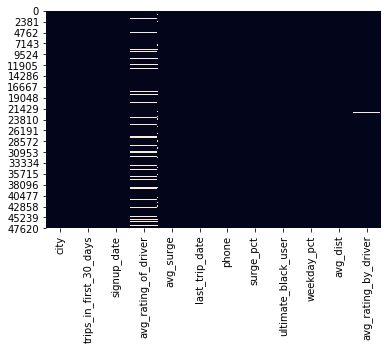

In [6]:
sns.heatmap(df.isnull(), cbar=False)

In [7]:
df['avg_rating_by_driver'].shape[0] - df['avg_rating_by_driver'].dropna().shape[0]

201

We should impute the missing values. To see if we should use the mean or median, we'll see if the average rating of driver feature has a long tail or is relatively normal.

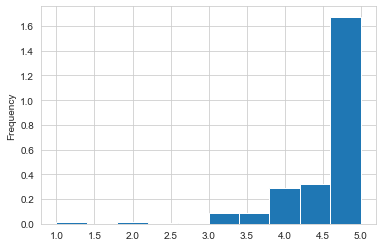

In [12]:
df['avg_rating_of_driver'].plot(kind='hist', bins=10, density=True)
plt.show()

In [13]:
df['avg_rating_of_driver'].mean()

4.601559291274655

In [14]:
df['avg_rating_of_driver'].median()

4.9

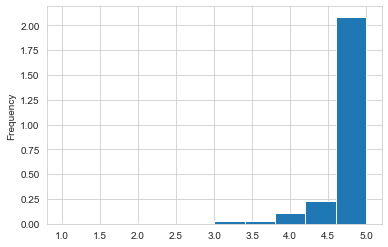

In [15]:
df['avg_rating_by_driver'].plot(kind='hist', bins=10, density=True)
plt.show()

In [16]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())

In [17]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

*N.B. It would normally be train-test contamination to impute before train-test split, but both these features skew so heavily toward the extreme end of the scale, this shouldn't make a difference if both train and test preserve the data's distribution feature by feature.*

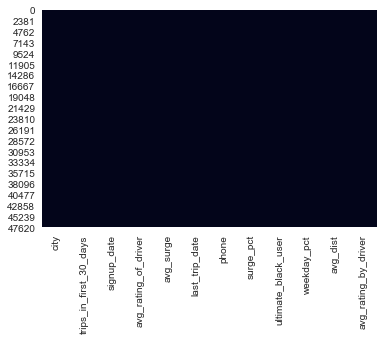

In [18]:
sns.heatmap(df.isnull(), cbar=False)

In [19]:
df.shape[0] - df.dropna().shape[0]

396

### Deal with "None" value for Phone

In [20]:
df[df.isna().any(axis=1)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
134,King's Landing,0,2014-01-10,5.000000,1.00,2014-06-11,None,0.0,False,100.0,2.88,5.0
176,Astapor,0,2014-01-28,5.000000,1.00,2014-03-18,None,0.0,False,100.0,20.32,5.0
320,Astapor,1,2014-01-08,5.000000,1.00,2014-01-09,None,0.0,False,100.0,31.01,5.0
349,Winterfell,1,2014-01-06,3.300000,1.00,2014-06-22,None,0.0,True,33.3,6.03,5.0
389,King's Landing,5,2014-01-26,4.900000,1.02,2014-07-01,None,3.0,False,66.7,3.08,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
49587,Winterfell,1,2014-01-17,5.000000,1.00,2014-01-19,None,0.0,True,0.0,1.15,3.0
49627,Astapor,6,2014-01-05,5.000000,1.00,2014-01-25,None,0.0,True,33.3,3.10,4.5
49666,Winterfell,2,2014-01-22,4.601559,1.00,2014-01-23,None,0.0,True,100.0,0.73,5.0
49825,Astapor,0,2014-01-25,5.000000,1.00,2014-03-10,None,0.0,True,50.0,5.82,5.0


In [21]:
df['phone'] = df['phone'].fillna('not reported')

In [22]:
df['phone'].unique()

array(['iPhone', 'Android', 'not reported'], dtype=object)

In [23]:
df.shape[0] - df.dropna().shape[0]

0

### clean datatypes

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [25]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [26]:
cat_cols = ['city', 'phone']
for cc in cat_cols:
    df[cc] = df[cc].astype('category')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null category
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.6 MB


## Exploration

A user's active if their last trip was within the past thirty days. We'll assume a perspective date of the latest datetime for purposes of this test...

In [28]:
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

...and say that a user's active if their last trip took place during June of 2014, or on July 1st.

In [34]:
df['label'] = np.where(df['last_trip_date'].dt.month.isin([6, 7]), 1, 0)

In [35]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,label
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [31]:
df['label'].value_counts(normalize=True)

0    0.63488
1    0.36512
Name: label, dtype: float64

Ultimate retained 63\% of users, where retained is defined as a non-zero number of trips in month six (June) of 2014.

## Predictive Modeling

Because the dataset combines numeric and categorical features, and because we have a binary yes/no label for user retention, I'm going to approach this as a binary classification problem, and I'm going to use a random forest classifier.

In [40]:
X = df[[c for c in df.columns if c != 'label']]
X.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Feature Architecture

Pull out hour of day, day of week, day of month, month of year for the two date features.

In [62]:
df['signup_hour'] = df['signup_date'].dt.hour
df['last_trip_hour'] = df['last_trip_date'].dt.hour

In [63]:
df['signup_weekday'] = df['signup_date'].dt.weekday_name
df['last_trip_weekday'] = df['last_trip_date'].dt.weekday_name

In [64]:
df['signup_day'] = df['signup_date'].dt.day
df['last_trip_day'] = df['last_trip_date'].dt.day

In [65]:
df['signup_month'] = df['signup_date'].dt.month
df['last_trip_month'] = df['last_trip_date'].dt.month

In [66]:
# drop date columns
date_cols = ['last_trip_date', 'signup_date']
X = X[[x for x in X.columns if x not in date_cols]]

In [67]:
X = pd.get_dummies(X)

In [68]:
y = df['label']
y.head()

0    1
1    0
2    0
3    1
4    0
Name: label, dtype: int64

In [79]:
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the classifier
rf_reg = RandomForestClassifier(n_estimators=1000, verbose=1, random_state=123)

# Fit the classifier to the training set
rf_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
y_pred = rf_reg.predict(X_test)

# Compute the rmse: rmse
area_under_roc_curve = roc_auc_score(y_test, y_pred)
print("area under roc curve: %f" % (area_under_roc_curve))
report = classification_report(y_test, y_pred)
print(report)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   23.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


area under roc curve: 0.737338
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6218
           1       0.69      0.66      0.67      3782

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.75      0.76      0.76     10000



[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


Text(0, 0.5, 'Feature')

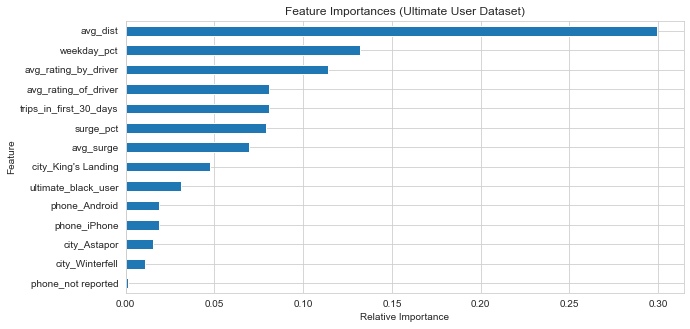

In [80]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rf_reg.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values('Gini-importance')
importances = importances.tail(30)
importances.plot(kind='barh', figsize=(10,5), legend=False)
plt.title('Feature Importances (Ultimate User Dataset)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
# plt.savefig('plots/ascapRandomForestRegFeatureImportance.png', bbox_inches='tight')

This model predicts user retention substantially better than guessing, as seen in the ROC AUC score of .74. The feature importance plot indicates that the number and total distance of drives taken in the first month of membership matter substantially in predicting retension. Ultimate might leverage these insights to increase long-term rider retention by maximizing the user's ride distance within their first thirty days of membership, through ridership incentives, for example. As one would find obvious, a good user experience for both use rand driver appears to matter, too: the user's ratings of rides, as well as drivers' ratings of the user, ranks high on the feature importance plot. After these features, the user's city of origin and phone brand play a small but negligible role in determining retention.